# Assignment 3
### Last updated: December 20, 2021

### Name: Aseem Sachdeva

### Uniqname: aseemsa

## Instructions

Please turn in:
1. A Jupyter Notebook file. This file should show all of the required work, including code, results, visualizations (if any), and necessary comments to your code. Irrelevant code and results should be deleted prior to submission.

2. An html file showing the preview of the Notebook. To create this file, select File -> Download as > HTML. 

### Before submitting, please select Kernel -> Restart & Run All.

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from networkx.drawing.nx_pydot import graphviz_layout
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep
import operator
import random

In [2]:
import heapq
from operator import itemgetter
import pandas as pd
from collections import Counter

## German highway system network

The data source used in this assignment is adopted and modified from the original Matlab file on the [website](http://www.biological-networks.org/?page_id=25). You can read more about the data source in its [paper](https://www.dynamic-connectome.org/pubs/Kaiser2004b.pdf).

> Kaiser M., and Hilgetag C.-C. (2004) Spatial growth of real-world networks. Physical Review E 69:036103.

### Q1. (1 point) Load the graph from the dataset. How many nodes in the graph have a degree of one?

In [3]:
G=nx.read_edgelist("assets/german.txt", delimiter=' ')
 # assign it with the number of nodes of degree one
degree_dict = dict(nx.degree(G))

# YOUR CODE HERE
degree_is_one = sum(x == 1 for x in degree_dict.values())



In [4]:
#hidden tests for Question 1 are within this cell

## Part 1. Diffusion models

In this part, you will practice simulating diffusion process on the graph with several difussion models we have learned.

### Q2. (7 points) Threshold model

Use the [threshold model](https://ndlib.readthedocs.io/en/latest/reference/models/epidemics/Threshold.html) provided by the NDlib library:

```python
ndlib.models.epidemics.ThresholdModel.ThresholdModel(graph, seed=None)
```

Complete the following function with the given signature, so that it simulates a diffusion process with a threshold model and returns a list of infected number in each iteration.

The function has two options for determining seed nodes:
- Passing a function as input (```importance_measure```), which takes in G and outputs a dictionary with nodes as the keys and scores as the values. Our function should use the top `n` nodes based on these scores as the seed nodes. For example, ```importance_measure``` could output a dictionary with the degree of each node. 

- If ```importance_measure``` is not passed, then our function should pick a random ```float(n)/len(G.nodes)``` fraction of nodes to be infected.  

**Hint**

The `ModelConfig` object supports two configuration parameters:

- To specify a list of initially infected nodes `infected_nodes` use:
    ```python
    config.add_model_initial_configuration("Infected", infected_nodes)
    ``` 
- To choose a random fraction of infected nodes use:
    ```python
    config.add_model_parameter('fraction_infected', fraction)
    ```


In [5]:
def simulate_threshold(G, importance_measure=None, iterate=50, n=1, threshold=0.25):
    model = ep.ThresholdModel(G, seed = 42)
    config = mc.Configuration()
    fraction = float(n)/len(G.nodes)

    if importance_measure:
        # select seed nodes
        sorted_node = sorted(importance_measure(G).items(), key=operator.itemgetter(1))[::-1]
        highest_nodes = [n for n, _ in sorted_node[:n]]
        config.add_model_initial_configuration("Infected", highest_nodes)
        
    elif importance_measure == None:
        # select seed nodes
        config.add_model_parameter('fraction_infected', fraction)
        
    for i in G.nodes():
        config.add_node_configuration("threshold", i, threshold)

    model.set_initial_status(config)
    
    # Simulation execution
    iterations = model.iteration_bunch(iterate)
    return [it['node_count'][1] for it in iterations]

In [6]:
#hidden tests for Question 2 are within this cell

### Q3. (3 points) Selection of seed nodes

Compare 5 different settings of seed nodes:

- randomly select `N` nodes
- select `N` nodes with the highest degree
- select `N` nodes with the highest closeness centrality
- select `N` nodes with the highest betweenness centrality
- select `N` nodes with the highest PageRank value



Use the function in question 2 to simulate the diffusion for each seed node set, with `iterate=50`, `N=5`, and  `threshold=0.3`.   Create a single plot with 5 curves (one for each set of seed nodes) with iteration number on the x-axis and the number of infected nodes on the y-axis.

**Note**: please do not modify the random seed. This is to ensure that your simulation will be consistent with the autograder.

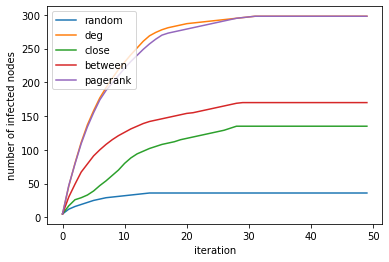

In [7]:
I=50
N=5
T=0.3
random.seed(42)
node_count_random = simulate_threshold(G, None, iterate=I, n=N, threshold=T)     # number of infected nodes in each iteration, init with randomly selected nodes
node_count_deg = simulate_threshold(G, nx.degree_centrality, iterate=I, n=N, threshold=T)       # number of infected nodes in each iteration, init with nodes of highest degree
node_count_closeness = simulate_threshold(G, nx.closeness_centrality, iterate=I, n=N, threshold=T) # number of infected nodes in each iteration, init with nodes of highest closeness centrality
node_count_betweenness =  simulate_threshold(G, nx.betweenness_centrality, iterate=I, n=N, threshold=T) # number of infected nodes in each iteration, init with nodes of highest betweenness centrality
node_count_pagerank = simulate_threshold(G, nx.pagerank, iterate=I, n=N, threshold=T)   # number of infected nodes in each iteration, init with nodes of highest pagerank 

# YOUR CODE HERE

data_tuples = list(zip(node_count_random,node_count_deg, node_count_closeness, node_count_betweenness, node_count_pagerank))

df = pd.DataFrame(data_tuples, columns=['random','deg', 'close', 'between', 'pagerank'])

df['iteration'] = np.arange(len(df))




plt.plot(df['iteration'], df['random'], label = "random")
plt.plot(df['iteration'], df['deg'], label = "deg")
plt.plot(df['iteration'], df['close'], label = "close")
plt.plot(df['iteration'], df['between'], label = "between")
plt.plot(df['iteration'], df['pagerank'], label = "pagerank")
plt.xlabel("iteration")
plt.ylabel("number of infected nodes")
plt.legend(loc="upper left")
plt.show()

In [8]:
#hidden tests for Question 3 are within this cell

### Q4. (1 point) Which seed nodes generation methods converges first?

### Informally, we say that a method converges when the number of infected nodes stops changing significantly as the number of iterations increases. 

Accepted strings:
```python
"random" | "degree" | "closeness" | "betweenness" | "pagerank"
```
Select all that apply to the list in the following cell. For example, if "closeness" and "degree" are the equally fast and converge first, you should input
```python
method = ["closeness", "degree"]
```


In [9]:

# YOUR CODE HERE
method = ["random"]

In [10]:
#hidden tests for Question 4 are within this cell

### Q5. (3 points) Randomized threshold model
We can add randomness to the threshold model by randomly assigning thresholds to the nodes.

Modify the function you wrote in Q2. Instead of setting the same threshold value for each node, use the `random.uniform(lower, upper)` function to randomly generate a threshold between $[lower, upper)$. 

In [11]:
def simulate_rand_threshold(G, importance_measure=None, iterate=100, n=1, lower=0, upper=1):
    model = ep.ThresholdModel(G, seed = 42)
    config = mc.Configuration()
    fraction = float(n)/len(G.nodes)

    if importance_measure:
        # select seed nodes
        sorted_node = sorted(importance_measure(G).items(), key=operator.itemgetter(1))[::-1]
        highest_nodes = [n for n, _ in sorted_node[:n]]
        config.add_model_initial_configuration("Infected", highest_nodes)
        
    elif importance_measure == None:
        # select seed nodes
        config.add_model_parameter('fraction_infected', fraction)
        
    for i in G.nodes():
        config.add_node_configuration("threshold", i, random.uniform(lower, upper))

    model.set_initial_status(config)
    
    # Simulation execution
    iterations = model.iteration_bunch(iterate)
    return [it['node_count'][1] for it in iterations]

In [12]:
#hidden tests for Question 5 are within this cell

### Q6. (4 points) Threshold range selection

Find a range $[a, b)$ such that the seed nodes selected using a random approach **converges** faster than at least one other method. You should run at least 50 iterations.

**Hint**: You can solve through trial and error, but think about what range of values would lead to slower convergence of the random strategy. There is no exact answer, but you can reason about the range of values that could work. What happens if the thresholds are all very large? Very small? Mid-range?

In [13]:
a = 0.3  # seleted lower bound
b = 0.4 # seleted upper bound






# YOUR CODE HERE


In [14]:
x = simulate_rand_threshold(G, n=N, iterate=I, lower=a, upper=b)
r1 = simulate_rand_threshold(G, nx.degree_centrality, n=N, iterate=I, lower=a, upper=b)
r2 = simulate_rand_threshold(G, nx.closeness_centrality, n=N, iterate=I, lower=a, upper=b)
r3 = simulate_rand_threshold(G, nx.betweenness_centrality, n=N, iterate=I, lower=a, upper=b)
r4 = simulate_rand_threshold(G, nx.pagerank, n=N, iterate=I, lower=a, upper=b)

#hidden tests for Question 6 are within this cell

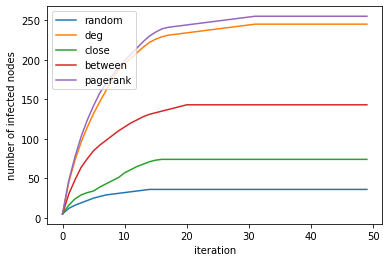

In [15]:
data_tuples = list(zip(x,r1, r2, r3, r4))

df = pd.DataFrame(data_tuples, columns=['random','deg', 'close', 'between', 'pagerank'])

df['iteration'] = np.arange(len(df))




plt.plot(df['iteration'], df['random'], label = "random")
plt.plot(df['iteration'], df['deg'], label = "deg")
plt.plot(df['iteration'], df['close'], label = "close")
plt.plot(df['iteration'], df['between'], label = "between")
plt.plot(df['iteration'], df['pagerank'], label = "pagerank")
plt.xlabel("iteration")
plt.ylabel("number of infected nodes")
plt.legend(loc="upper left")
plt.show()

### Q7. (5 points) Independent cascade model

The [independent cascade model](https://ndlib.readthedocs.io/en/latest/reference/models/epidemics/IndependentCascades.html) also has a threshold parameter. Note that this threshold is not the same as the threshold of the threshold model. Here it is specified for edges and represents the probability of diffusion along each edge.

Complete the following function with the given signature, so that it simulates a diffusion process with an independent cascade model and returns a list of the number infected in each iteration. The seed nodes should be selected in the same way as in Q2. 

In [16]:
def simulate_IC(G, importance_measure=None, iterate=100, n=1, threshold=0.3):
    model = ep.IndependentCascadesModel(G)
    random.seed(42)
    config = mc.Configuration()
    fraction = float(n)/len(G.nodes)

    if importance_measure:
        # select seed nodes
        sorted_node = sorted(importance_measure(G).items(), key=operator.itemgetter(1))[::-1]
        highest_nodes = [n for n, _ in sorted_node[:n]]
        config.add_model_initial_configuration("Infected", highest_nodes)
        
    elif importance_measure == None:
        # select seed nodes
        config.add_model_parameter('fraction_infected', fraction)
        
    for e in G.edges():
        config.add_edge_configuration("threshold", e, threshold)

    model.set_initial_status(config)
    
    # Simulation execution
    iterations = model.iteration_bunch(iterate)
    return [it['node_count'][1] + it['node_count'][2] for it in iterations]  # number of people who already know

### Q8. (5 points) Seed node comparison

Apply the same comparison on the 5 seed node sets for the independent cascade model with the function you implemented in Q7. Set the parameters as `N=20`, `iterate=40` and `threshold=0.3`.

Create a single plot with 5 curves (one for each set of seed nodes) with iteration number on the x-axis and the number of infected nodes on the y-axis.


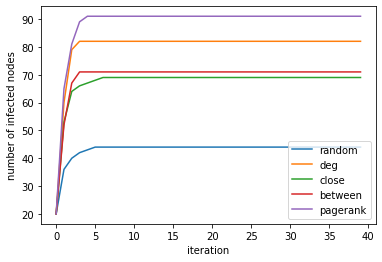

In [17]:
I=40
N=20
T=0.3
node_count_random = simulate_IC(G, importance_measure=None, iterate=I, n=N, threshold=T)    # number of infected nodes in each iteration, init with randomly selected nodes
node_count_deg = simulate_IC(G, importance_measure=nx.degree_centrality, iterate=I, n=N, threshold=T)         # number of infected nodes in each iteration, init with nodes of highest degree
node_count_closeness= simulate_IC(G, importance_measure=nx.closeness_centrality, iterate=I, n=N, threshold=T)  # number of infected nodes in each iteration, init with nodes of highest closeness centrality
node_count_betweenness = simulate_IC(G, importance_measure=nx.betweenness_centrality, iterate=I, n=N, threshold=T)  # number of infected nodes in each iteration, init with nodes of highest betweenness centrality
node_count_pagerank = simulate_IC(G, importance_measure=nx.pagerank, iterate=I, n=N, threshold=T)   # number of infected nodes in each iteration, init with nodes of highest pagerank 

# YOUR CODE HERE
data_tuples = list(zip(node_count_random,node_count_deg, node_count_closeness, node_count_betweenness, node_count_pagerank))

df = pd.DataFrame(data_tuples, columns=['random','deg', 'close', 'between', 'pagerank'])

df['iteration'] = np.arange(len(df))




plt.plot(df['iteration'], df['random'], label = "random")
plt.plot(df['iteration'], df['deg'], label = "deg")
plt.plot(df['iteration'], df['close'], label = "close")
plt.plot(df['iteration'], df['between'], label = "between")
plt.plot(df['iteration'], df['pagerank'], label = "pagerank")
plt.xlabel("iteration")
plt.ylabel("number of infected nodes")
plt.legend(loc="lower right")
plt.show()


### Q9. (2 points) Which method results in the largest cascade size?

Accepted strings:
```python
"random" | "degree" | "closeness" | "betweenness" | "pagerank"
```
Select all that apply to the list in the following cell. For example, if "random" and "degree" are both the fastest, you should input

```python
method = ["random", "degree"]
```

In [18]:
method = ['pagerank']

# YOUR CODE HERE


In [19]:
#hidden tests for Question 9 are within this cell

### Q10. (5 points) SI model

The [SI model](https://ndlib.readthedocs.io/en/latest/reference/models/epidemics/SIm.html) considers two states: "susceptible" and "infected". The statuses are interpreted as: 

|Name	|Code
|---    |--- 
|Susceptible|0
|Infected	|1

The infection probability is given by the parameter `beta`, which should be between 0 and 1. 


Complete the following function with the given signature, so that it simulates a diffusion process with an SI model and returns a list of currently infected number in each iteration.


In [20]:
def simulate_SI(G, importance_measure=None, iterate=100, n=1, beta=0.1):
    # Model selection
    model = ep.SIModel(G)
    config = mc.Configuration()
    fraction = float(n)/len(G.nodes)
    
    if importance_measure:
        # select seed nodes
        sorted_node = sorted(importance_measure(G).items(), key=operator.itemgetter(1))[::-1]
        highest_nodes = [n for n, _ in sorted_node[:n]]
        config.add_model_initial_configuration("Infected", highest_nodes)
        
    elif importance_measure == None:
        # select seed nodes
        config.add_model_parameter('fraction_infected', fraction)    
        

    config.add_model_parameter('beta', beta)
    model.set_initial_status(config)

    # YOUR CODE HERE
  

    # Simulation execution
    iterations = model.iteration_bunch(iterate)
    return [it['node_count'][1] for it in iterations]

### Q11. (3 points) Seed node comparison
Apply the same comparison on the 5 seed node sets for the SI model with the function you implemented in question 10. Set the parameters `N=5`, `iterate=300`, `beta=0.1`.


Create a single plot with 5 curves (one for each set of seed nodes) with iteration number on the x-axis and the number of currently infected nodes on the y-axis.

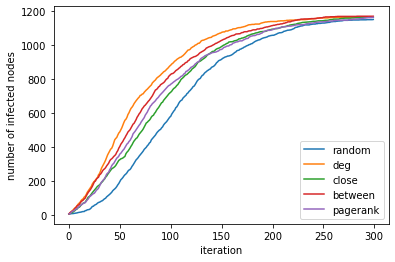

In [21]:
random.seed(42)
N=5
I=300
b = 0.1
node_count_random = simulate_SI(G, importance_measure=None, iterate=I, n=N, beta=b)     # number of infected nodes in each iteration, init with randomly selected nodes
node_count_deg = simulate_SI(G, importance_measure=nx.degree_centrality, iterate=I, n=N, beta=b)        # number of infected nodes in each iteration, init with nodes of highest degree
node_count_closeness= simulate_SI(G, importance_measure=nx.closeness_centrality, iterate=I, n=N, beta=b)   # number of infected nodes in each iteration, init with nodes of highest closeness centrality
node_count_betweenness = simulate_SI(G, importance_measure=nx.betweenness_centrality, iterate=I, n=N, beta=b)  # number of infected nodes in each iteration, init with nodes of highest betweenness centrality
node_count_pagerank = simulate_SI(G, importance_measure=nx.pagerank, iterate=I, n=N, beta=b)   # number of infected nodes in each iteration, init with nodes of highest pagerank 

# YOUR CODE HERE

data_tuples = list(zip(node_count_random,node_count_deg, node_count_closeness, node_count_betweenness, node_count_pagerank))

df = pd.DataFrame(data_tuples, columns=['random','deg', 'close', 'between', 'pagerank'])

df['iteration'] = np.arange(len(df))




plt.plot(df['iteration'], df['random'], label = "random")
plt.plot(df['iteration'], df['deg'], label = "deg")
plt.plot(df['iteration'], df['close'], label = "close")
plt.plot(df['iteration'], df['between'], label = "between")
plt.plot(df['iteration'], df['pagerank'], label = "pagerank")
plt.xlabel("iteration")
plt.ylabel("number of infected nodes")
plt.legend(loc="lower right")
plt.show()




### Q12. (5 points) SIR model

The [SIR model](https://ndlib.readthedocs.io/en/latest/reference/models/epidemics/SIR.html) has one more state than the SI model:

|Name	|Code
|---|---
|Susceptible	|0
|Infected	|1
|Removed	|2

And in addition to `beta`, it has an additional `gamma` parameter which indicates removal probability. Complete the following function with the given signature, so that it simulates a diffusion process with a SIR model and returns a list of the number of currently infected nodes and the cumulative number of infected nodes at each iteration. 

#### Notice
For the SIR model, since it has an additional recovery stage, the numer of infected nodes can decrease. Therefore, the function `simulate_SIR` will return two lists: one is the same as before --- the number of currently infected nodes. The other one (`total_infected_nodes`) is the total number of nodes that have been infected at least once across all iterations, whether or not they have recovered. 

In [22]:
def simulate_SIR(G, importance_measure=None, iterate=100, n=1, beta=0.1, gamma=0.05):
    # write your code for model configuration here
    # Model Configuration
    ###
    random.seed(42)
    model = ep.SIRModel(G)
    config = mc.Configuration()
    config.add_model_parameter("beta", beta)
    config.add_model_parameter("gamma", gamma)
    fraction = float(n)/len(G.nodes) 
    
    if importance_measure:
        # select seed nodes
        sorted_node = sorted(importance_measure(G).items(), key=operator.itemgetter(1))[::-1]
        highest_nodes = [n for n, _ in sorted_node[:n]]
        config.add_model_initial_configuration("Infected", highest_nodes)
    
        model.set_initial_status(config)
    
    elif importance_measure==None:
   
        config.add_model_parameter("fraction_infected", fraction)
        
        model.set_initial_status(config)


    # Simulation execution
    iterations = model.iteration_bunch(iterate)
    
    total_infected_nodes = [0] * iterate
    # write your code for computing total number of infected nodes here
    ###
    total_infected_nodes = [(it['node_count'][1] + it['node_count'][2]) for it in iterations]
    ###

    return [it['node_count'][1] for it in iterations], total_infected_nodes

### Q13. (6 points) Seed node comparison

Apply the same comparison on the 5 seed node sets for the SIR model with the function you implemented in question 12. Set the parameters `N=25`, `iterate=300`, `beta=0.1`, `gamma=0.05`.

(a) Create a single plot with 5 curves (one for each set of seed nodes) with iteration number on the x-axis and the number of currently infected nodes on the y-axis.

(b) Create a single plot with 5 curves (one for each set of seed nodes) with iteration number on the x-axis and the total number of nodes that have ever been infected up to the current iteration on the y-axis.

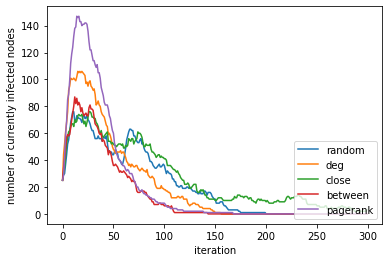

In [23]:
N=25
I=300
b = 0.1
g = 0.05

node_count_random = simulate_SIR(G, importance_measure=None, iterate=I, n=N, beta=b, gamma=g)[0]     # number of infected nodes in each iteration, init with randomly selected nodes
node_count_deg = simulate_SIR(G, importance_measure=nx.degree_centrality, iterate=I, n=N, beta=b, gamma=g)[0]         # number of infected nodes in each iteration, init with nodes of highest degree
node_count_closeness= simulate_SIR(G, importance_measure=nx.closeness_centrality, iterate=I, n=N, beta=b, gamma=g)[0]    # number of infected nodes in each iteration, init with nodes of highest closeness centrality
node_count_betweenness = simulate_SIR(G, importance_measure=nx.betweenness_centrality, iterate=I, n=N, beta=b, gamma=g)[0]  # number of infected nodes in each iteration, init with nodes of highest betweenness centrality
node_count_pagerank = simulate_SIR(G, importance_measure=nx.pagerank, iterate=I, n=N, beta=b, gamma=g)[0]    # number of infected nodes in each iteration, init with nodes of highest pagerank 

# YOUR CODE HERE
data_tuples = list(zip(node_count_random,node_count_deg, node_count_closeness, node_count_betweenness, node_count_pagerank))

df = pd.DataFrame(data_tuples, columns=['random','deg', 'close', 'between', 'pagerank'])

df['iteration'] = np.arange(len(df))




plt.plot(df['iteration'], df['random'], label = "random")
plt.plot(df['iteration'], df['deg'], label = "deg")
plt.plot(df['iteration'], df['close'], label = "close")
plt.plot(df['iteration'], df['between'], label = "between")
plt.plot(df['iteration'], df['pagerank'], label = "pagerank")
plt.xlabel("iteration")
plt.ylabel("number of currently infected nodes")
plt.legend(loc="lower right")
plt.show()



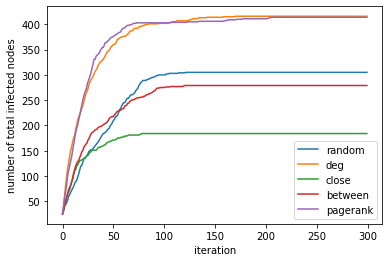

In [24]:
node_count_random = simulate_SIR(G, importance_measure=None, iterate=I, n=N, beta=b, gamma=g)[1]     # number of infected nodes in each iteration, init with randomly selected nodes
node_count_deg = simulate_SIR(G, importance_measure=nx.degree_centrality, iterate=I, n=N, beta=b, gamma=g)[1]         # number of infected nodes in each iteration, init with nodes of highest degree
node_count_closeness= simulate_SIR(G, importance_measure=nx.closeness_centrality, iterate=I, n=N, beta=b, gamma=g)[1]    # number of infected nodes in each iteration, init with nodes of highest closeness centrality
node_count_betweenness = simulate_SIR(G, importance_measure=nx.betweenness_centrality, iterate=I, n=N, beta=b, gamma=g)[1]  # number of infected nodes in each iteration, init with nodes of highest betweenness centrality
node_count_pagerank = simulate_SIR(G, importance_measure=nx.pagerank, iterate=I, n=N, beta=b, gamma=g)[1]    # number of infected nodes in each iteration, init with nodes of highest pagerank 

# YOUR CODE HERE
data_tuples = list(zip(node_count_random,node_count_deg, node_count_closeness, node_count_betweenness, node_count_pagerank))

df = pd.DataFrame(data_tuples, columns=['random','deg', 'close', 'between', 'pagerank'])

df['iteration'] = np.arange(len(df))




plt.plot(df['iteration'], df['random'], label = "random")
plt.plot(df['iteration'], df['deg'], label = "deg")
plt.plot(df['iteration'], df['close'], label = "close")
plt.plot(df['iteration'], df['between'], label = "between")
plt.plot(df['iteration'], df['pagerank'], label = "pagerank")
plt.xlabel("iteration")
plt.ylabel("number of total infected nodes")
plt.legend(loc="lower right")
plt.show()


### Q14. (5 points) SIS model

The [SIS model](https://ndlib.readthedocs.io/en/latest/reference/models/epidemics/SIS.html) has two states: susceptible and infected:

|Name	|Code
|---|---
|Susceptible	|0
|Infected	|1

And in addition to `beta`, it has an additional `lambda` parameter which indicates the probability of an infected node transferring back to the susceptible state. Complete the following function with the given signature, so that it simulates a diffusion process with an SIS model and returns a list of infected number in each iteration.

#### Notice
`lambda` is a reserved keyword in Python, so we use `_lambda` instead in the function argument.

In [25]:
def simulate_SIS(G, importance_measure=None, iterate=100, n=1, beta=0.1, _lambda=0.05):
    
    model = ep.SISModel(G)
    config = mc.Configuration()
    fraction = float(n)/len(G.nodes) 
    config.add_model_parameter('beta', beta)
    config.add_model_parameter('lambda', _lambda)
    
    
    if importance_measure:
        # select seed nodes
        sorted_node = sorted(importance_measure(G).items(), key=operator.itemgetter(1))[::-1]
        highest_nodes = [n for n, _ in sorted_node[:n]]
        config.add_model_initial_configuration("Infected", highest_nodes)
        model.set_initial_status(config)
 

    elif importance_measure == None:
        config.add_model_parameter("fraction_infected", fraction)
        
        model.set_initial_status(config)
    
    
    
    
    
    
    

    # Simulation execution
    iterations = model.iteration_bunch(iterate)
    return [it['node_count'][1] for it in iterations]

### Q15. (3 points) Seed node comparison

Apply the same comparison on the 5 seed node sets for the SIS model with the function you implemented in question 14. 

Set parameters `N=5`, `iterate=700`, `beta=0.1`, `lambda=0.05`.

Create a single plot with 5 curves (one for each set of seed nodes) with iteration number on the x-axis and the number of currently infected nodes on the y-axis.

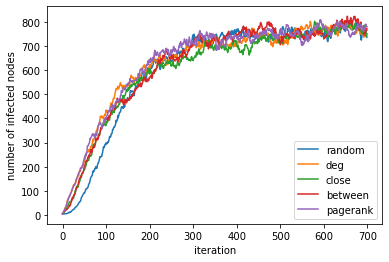

In [26]:
N=5
I=700
b = 0.1
l = 0.05

node_count_random = simulate_SIS(G, importance_measure=None, iterate=I, n=N, beta=b, _lambda=l)     # number of infected nodes in each iteration, init with randomly selected nodes
node_count_deg = simulate_SIS(G, importance_measure=nx.degree_centrality, iterate=I, n=N, beta=b, _lambda=l)        # number of infected nodes in each iteration, init with nodes of highest degree
node_count_closeness= simulate_SIS(G, importance_measure=nx.closeness_centrality, iterate=I, n=N, beta=b, _lambda=l)  # number of infected nodes in each iteration, init with nodes of highest closeness centrality
node_count_betweenness = simulate_SIS(G, importance_measure=nx.betweenness_centrality, iterate=I, n=N, beta=b, _lambda=l)  # number of infected nodes in each iteration, init with nodes of highest betweenness centrality
node_count_pagerank = simulate_SIS(G, importance_measure=nx.pagerank, iterate=I, n=N, beta=b, _lambda=l)   # number of infected nodes in each iteration, init with nodes of highest pagerank 

# YOUR CODE HERE
data_tuples = list(zip(node_count_random,node_count_deg, node_count_closeness, node_count_betweenness, node_count_pagerank))

df = pd.DataFrame(data_tuples, columns=['random','deg', 'close', 'between', 'pagerank'])

df['iteration'] = np.arange(len(df))




plt.plot(df['iteration'], df['random'], label = "random")
plt.plot(df['iteration'], df['deg'], label = "deg")
plt.plot(df['iteration'], df['close'], label = "close")
plt.plot(df['iteration'], df['between'], label = "between")
plt.plot(df['iteration'], df['pagerank'], label = "pagerank")
plt.xlabel("iteration")
plt.ylabel("number of infected nodes")
plt.legend(loc="lower right")
plt.show()


### Q16. (5 points) SI, SIR, SIS

Compare the plots of the number of currently infected nodes of the SI, SIR, and SIS models and answer the following questions with a written response. 


1. Which model is the first to converge? Why do you think this model converges first?
2. Which model is the last to converge? Why do you think this model converges last?
3. Which model has the largest final number of infected nodes? Why?
4. Which model has the smallest final number of infected nodes? Why?
5. Why does the SIS model fail to completely stabilize in terms of the number of infected nodes?

1. The independent cascade model converges first for essentially every importance measure. With each iteration, each node only has one shot at infecting its neighbors, and cannot do so in subsequent iterations even if it fails. This means that it will typically run out of activations relatively quickly. 

2. The model that is the last to converge(excluding the SIS model which doesn't actually end up converging) is the SI model. This model likely converges last because the probability of a node being infected is entirely dependent on the variable beta, in the sense that all of the nodes will share that probability of infection(which is a somewhat unrealistic assumption). In this case, the probability of infection was set to 0.10, or 10%, which means that at any given iteration, the probability of a given node being infected is only 10%.

3. The model with the largest final number of infected nodes is the SI model. This is likely the case because unlike the SIR or the SIS model, when a node is infected, it stays in the infected state forever. With the SIR model and SIS model, however, the state of a node can change from iteration to iteration(i.e. infected to susceptible or infected to removed.

4. The model with the smallest final number of infected nodes is the independent cascade model. This is likely because activations run out relatively quickly, as aforementioned, so new nodes stop getting infected at a much earlier iteration.

5. The SIS model fails to completely stabilize because, unlike the SIR model, nodes are never removed during any iteration, and only revert from infected to susceptible, which means that any given node has a chance of getting infected and subsequently recovering multiple times. This is why the lines never quite converge. However, it is possible that increasing the parameter lambda(probability of nodes becoming susceptible) would cause the lines to stabilize more quickly, as that would cause the nodes to linger in the infected state for a shorter period of time. If probability of infection remains constant, then increasing the probability of a node becoming susceptible will cause the lines to converge more quickly.

---
## Part 2. Alternate threshold model

In this part, you are going to make some modifications to the threshold model to create a new model and compare it with the original version.

### Q17.  (10 points) The Volatile Threshold model class

In the below cell, an incomplete class `VolatileThreshold` is provided. The diffusion rule for the volatile threshold model is the following:

> In each iteration, only a random subset of `n` neighbors for each node `v` is evaluated. If the ratio of infection is ***at or above*** the threshold of `v` *within the subset*, then node `v` will become infected. A parameter `sample` determines the number of neighbors to sample. 

Based on this specification of the model, complete the `iteration` method. Please do not make any changes to the rest of the class. 

--- 
#### Notes

1. If the sample size is ***larger*** than the number of neighbors a node has, just take all its neighbors as a sample.
2. You can use the function `random.sample(original_data, sample_size)` to get a sample of size `sample_size` from collection `original_data`.
3. `class` object: in this part, we introduce a class object to construct our `VolatileThreshold` model. In Python, each class maintains its member attributes and methods with the `self` keyword. For example, `self.G`, `self.config` are simply `G` and `config` and belong to a specific instance of this class. You can see more in this [tutorial](https://www.w3schools.com/python/python_classes.asp).

In [27]:
from tqdm import tqdm
class VolatileThreshold:
    def __init__(self, graph):
        self.G = graph
        self.config = None
        self.status = {n: 0 for n in graph.nodes}
        self.threshold = {n: 0 for n in graph.nodes}
        self.num_sample = 0  # since the graph is connected
        self.N = len(graph.nodes)
        
    def set_initial_status(self, config):
        self.config = config
        # set threshold
        thred = config.__dict__['config']['nodes']['threshold']
        for n in self.G.nodes:
            self.threshold[n] = thred[n]
        # set number of samples
        self.num_sample = config.__dict__['config']['model']['num_sample']
        # set seed nodes
        if 'fraction_infected' in config.__dict__['config']['model']:
                seed_nodes = random.sample(
                    self.G.nodes(), int(config.__dict__['config']['model']['fraction_infected'] * len(self.G.nodes())))
        else:
            seed_nodes = config.__dict__['config']['status']['Infected']
        for n in seed_nodes:
            self.status[n] = 1
    
    def iteration(self):
        num_infected_nodes_total = 0  # number of infected node (with status 1)
        tmp = {n: self.status[n] for n in self.G.nodes}
        for n in self.G.nodes:
            if self.status[n] == 0:
                
                num_infected_nodes_in_sample = 0 # initiate a counter for n's infected neighbors
                
                neighbors = list(self.G.neighbors(n))
                if len(neighbors) > self.num_sample:
                    # get a sample of n's neighbors neighbors of size self.num_sample
                    # YOUR CODE HERE
                    sampled_neighbors = random.sample(neighbors, self.num_sample)
                else:
                    sampled_neighbors = neighbors
                
                # count the number of infected neighbors in the sampled neighbors using the statuses stored in tmp
                # YOUR CODE HERE
                for node in sampled_neighbors:
                    if tmp[node] == 1:
                        num_infected_nodes_in_sample +=1
                
                # compute the ratio of infected nodes in the sampled neighbors
                # YOUR CODE HERE
                ratio = num_infected_nodes_in_sample / len(sampled_neighbors)
                
                # if the ratio is AT OR ABOVE n's threshold (self.threshold[n]), the node becomes infected. 
                # in this case, update self.status[n] to 1 and increase the count of total infected nodes by 1
                # YOUR CODE HERE
                if ratio >= self.threshold[n]:
                    self.status[n] = 1
                    num_infected_nodes_total +=1
            else:
                num_infected_nodes_total += 1
        return num_infected_nodes_total
    
    
    
    def iteration_bunch(self, bunch_size):
        results = []
        num_infected_nodes_total = 0
        for n in self.G.nodes:
            num_infected_nodes_total += self.status[n]
        results.append({0: self.N - num_infected_nodes_total, 1: num_infected_nodes_total})
        for i in tqdm(range(bunch_size)):
            num_infected_nodes_total = self.iteration()
            results.append({0: self.N - num_infected_nodes_total, 1: num_infected_nodes_total})
        return results

### Q18. (7 points) Seed nodes comparison

Complete the following function with the given signature, so that it simulates a diffusion process with the volatile threshold model and returns a list of infected number in each iteration.

In [28]:
def simulate_volatile(G, importance_measure=None, iterate=100, n=1, threshold=0.5, sample=5):
    
    # Model selection
    model = VolatileThreshold(G)
    random.seed(0)   
    config = mc.Configuration()
    fraction = float(n)/len(G.nodes) 

    
    
    if importance_measure:
        # select seed nodes
        sorted_node = sorted(importance_measure(G).items(), key=operator.itemgetter(1))[::-1]
        highest_nodes = [n for n, _ in sorted_node[:n]]
        config.add_model_initial_configuration("Infected", highest_nodes)
        
        
    elif importance_measure == None:
        # select seed nodes
        config.add_model_parameter('fraction_infected', fraction)
        
    for i in G.nodes():
        config.add_node_configuration("threshold", i, threshold)
    
    config.add_model_parameter('num_sample', sample)

    model.set_initial_status(config)


    # YOUR CODE HERE
    

    # Simulation execution
    iterations = model.iteration_bunch(iterate)
    return [it[1] for it in iterations]  

In [29]:
# F = simulate_volatile(G, importance_measure=None, iterate=100, n=1, threshold=0.5, sample=5)
# F

In [30]:
#hidden tests for Question 18 are within this cell

### Q19. (12 points) Using parameters `I=100`, `N=10`, `T=0.5`, create a plot of the diffusion process when the sample size $S = [1, 2, 3, 4, 5,100]$, one in each cell. As we have done in previous questions, pick the seed nodes using the 5 different strategies: random, degree, closeness, betweenness, pagerank. 

100%|██████████| 100/100 [00:00<00:00, 1120.58it/s]


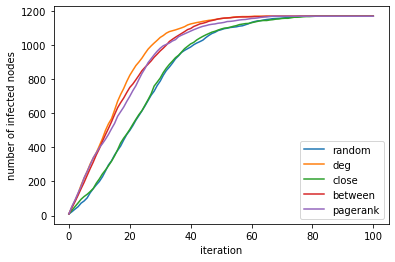

In [31]:
I=100
N=10
T = 0.5
S = 1

node_count_random = simulate_volatile(G, importance_measure=None, iterate=I, n=N, threshold=T, sample=S)    # number of infected nodes in each iteration, init with randomly selected nodes
node_count_deg = simulate_volatile(G, importance_measure=nx.degree_centrality, iterate=I, n=N, threshold=T, sample=S)        # number of infected nodes in each iteration, init with nodes of highest degree
node_count_closeness= simulate_volatile(G, importance_measure=nx.closeness_centrality, iterate=I, n=N, threshold=T, sample=S)  # number of infected nodes in each iteration, init with nodes of highest closeness centrality
node_count_betweenness = simulate_volatile(G, importance_measure=nx.betweenness_centrality, iterate=I, n=N, threshold=T, sample=S)  # number of infected nodes in each iteration, init with nodes of highest betweenness centrality
node_count_pagerank = simulate_volatile(G, importance_measure=nx.pagerank, iterate=I, n=N, threshold=T, sample=S)   # number of infected nodes in each iteration, init with nodes of highest pagerank 

# YOUR CODE HERE
data_tuples = list(zip(node_count_random,node_count_deg, node_count_closeness, node_count_betweenness, node_count_pagerank))

df = pd.DataFrame(data_tuples, columns=['random','deg', 'close', 'between', 'pagerank'])

df['iteration'] = np.arange(len(df))




plt.plot(df['iteration'], df['random'], label = "random")
plt.plot(df['iteration'], df['deg'], label = "deg")
plt.plot(df['iteration'], df['close'], label = "close")
plt.plot(df['iteration'], df['between'], label = "between")
plt.plot(df['iteration'], df['pagerank'], label = "pagerank")
plt.xlabel("iteration")
plt.ylabel("number of infected nodes")
plt.legend(loc="lower right")
plt.show()



100%|██████████| 100/100 [00:00<00:00, 2997.97it/s]


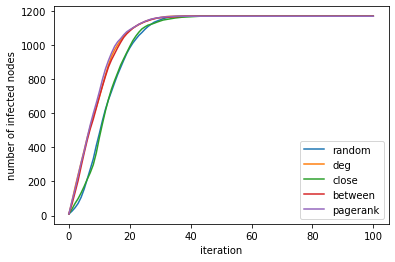

In [32]:
I=100
N=10
T = 0.5
S = 2

node_count_random = simulate_volatile(G, importance_measure=None, iterate=I, n=N, threshold=T, sample=S)    # number of infected nodes in each iteration, init with randomly selected nodes
node_count_deg = simulate_volatile(G, importance_measure=nx.degree_centrality, iterate=I, n=N, threshold=T, sample=S)        # number of infected nodes in each iteration, init with nodes of highest degree
node_count_closeness= simulate_volatile(G, importance_measure=nx.closeness_centrality, iterate=I, n=N, threshold=T, sample=S)  # number of infected nodes in each iteration, init with nodes of highest closeness centrality
node_count_betweenness = simulate_volatile(G, importance_measure=nx.betweenness_centrality, iterate=I, n=N, threshold=T, sample=S)  # number of infected nodes in each iteration, init with nodes of highest betweenness centrality
node_count_pagerank = simulate_volatile(G, importance_measure=nx.pagerank, iterate=I, n=N, threshold=T, sample=S)   # number of infected nodes in each iteration, init with nodes of highest pagerank 

# YOUR CODE HERE
data_tuples = list(zip(node_count_random,node_count_deg, node_count_closeness, node_count_betweenness, node_count_pagerank))

df = pd.DataFrame(data_tuples, columns=['random','deg', 'close', 'between', 'pagerank'])

df['iteration'] = np.arange(len(df))




plt.plot(df['iteration'], df['random'], label = "random")
plt.plot(df['iteration'], df['deg'], label = "deg")
plt.plot(df['iteration'], df['close'], label = "close")
plt.plot(df['iteration'], df['between'], label = "between")
plt.plot(df['iteration'], df['pagerank'], label = "pagerank")
plt.xlabel("iteration")
plt.ylabel("number of infected nodes")
plt.legend(loc="lower right")
plt.show()

100%|██████████| 100/100 [00:00<00:00, 1100.48it/s]


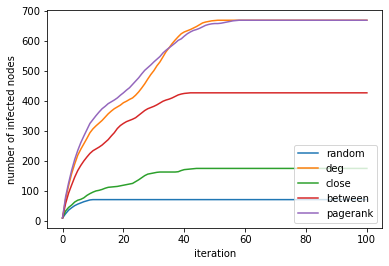

In [33]:
I=100
N=10
T = 0.5
S = 3

node_count_random = simulate_volatile(G, importance_measure=None, iterate=I, n=N, threshold=T, sample=S)    # number of infected nodes in each iteration, init with randomly selected nodes
node_count_deg = simulate_volatile(G, importance_measure=nx.degree_centrality, iterate=I, n=N, threshold=T, sample=S)        # number of infected nodes in each iteration, init with nodes of highest degree
node_count_closeness= simulate_volatile(G, importance_measure=nx.closeness_centrality, iterate=I, n=N, threshold=T, sample=S)  # number of infected nodes in each iteration, init with nodes of highest closeness centrality
node_count_betweenness = simulate_volatile(G, importance_measure=nx.betweenness_centrality, iterate=I, n=N, threshold=T, sample=S)  # number of infected nodes in each iteration, init with nodes of highest betweenness centrality
node_count_pagerank = simulate_volatile(G, importance_measure=nx.pagerank, iterate=I, n=N, threshold=T, sample=S)   # number of infected nodes in each iteration, init with nodes of highest pagerank 

# YOUR CODE HERE
data_tuples = list(zip(node_count_random,node_count_deg, node_count_closeness, node_count_betweenness, node_count_pagerank))

df = pd.DataFrame(data_tuples, columns=['random','deg', 'close', 'between', 'pagerank'])

df['iteration'] = np.arange(len(df))




plt.plot(df['iteration'], df['random'], label = "random")
plt.plot(df['iteration'], df['deg'], label = "deg")
plt.plot(df['iteration'], df['close'], label = "close")
plt.plot(df['iteration'], df['between'], label = "between")
plt.plot(df['iteration'], df['pagerank'], label = "pagerank")
plt.xlabel("iteration")
plt.ylabel("number of infected nodes")
plt.legend(loc="lower right")
plt.show()

100%|██████████| 100/100 [00:00<00:00, 1234.18it/s]


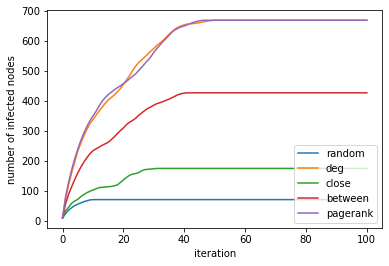

In [34]:
I=100
N=10
T = 0.5
S = 4

node_count_random = simulate_volatile(G, importance_measure=None, iterate=I, n=N, threshold=T, sample=S)    # number of infected nodes in each iteration, init with randomly selected nodes
node_count_deg = simulate_volatile(G, importance_measure=nx.degree_centrality, iterate=I, n=N, threshold=T, sample=S)        # number of infected nodes in each iteration, init with nodes of highest degree
node_count_closeness= simulate_volatile(G, importance_measure=nx.closeness_centrality, iterate=I, n=N, threshold=T, sample=S)  # number of infected nodes in each iteration, init with nodes of highest closeness centrality
node_count_betweenness = simulate_volatile(G, importance_measure=nx.betweenness_centrality, iterate=I, n=N, threshold=T, sample=S)  # number of infected nodes in each iteration, init with nodes of highest betweenness centrality
node_count_pagerank = simulate_volatile(G, importance_measure=nx.pagerank, iterate=I, n=N, threshold=T, sample=S)   # number of infected nodes in each iteration, init with nodes of highest pagerank 

# YOUR CODE HERE
data_tuples = list(zip(node_count_random,node_count_deg, node_count_closeness, node_count_betweenness, node_count_pagerank))

df = pd.DataFrame(data_tuples, columns=['random','deg', 'close', 'between', 'pagerank'])

df['iteration'] = np.arange(len(df))




plt.plot(df['iteration'], df['random'], label = "random")
plt.plot(df['iteration'], df['deg'], label = "deg")
plt.plot(df['iteration'], df['close'], label = "close")
plt.plot(df['iteration'], df['between'], label = "between")
plt.plot(df['iteration'], df['pagerank'], label = "pagerank")
plt.xlabel("iteration")
plt.ylabel("number of infected nodes")
plt.legend(loc="lower right")
plt.show()

100%|██████████| 100/100 [00:00<00:00, 1027.53it/s]


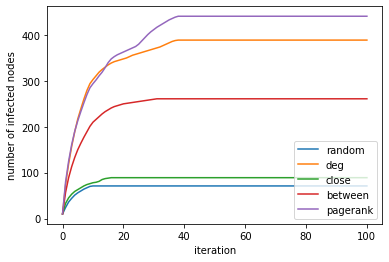

In [35]:
I=100
N=10
T = 0.5
S = 5

node_count_random = simulate_volatile(G, importance_measure=None, iterate=I, n=N, threshold=T, sample=S)    # number of infected nodes in each iteration, init with randomly selected nodes
node_count_deg = simulate_volatile(G, importance_measure=nx.degree_centrality, iterate=I, n=N, threshold=T, sample=S)        # number of infected nodes in each iteration, init with nodes of highest degree
node_count_closeness= simulate_volatile(G, importance_measure=nx.closeness_centrality, iterate=I, n=N, threshold=T, sample=S)  # number of infected nodes in each iteration, init with nodes of highest closeness centrality
node_count_betweenness = simulate_volatile(G, importance_measure=nx.betweenness_centrality, iterate=I, n=N, threshold=T, sample=S)  # number of infected nodes in each iteration, init with nodes of highest betweenness centrality
node_count_pagerank = simulate_volatile(G, importance_measure=nx.pagerank, iterate=I, n=N, threshold=T, sample=S)   # number of infected nodes in each iteration, init with nodes of highest pagerank 

# YOUR CODE HERE
data_tuples = list(zip(node_count_random,node_count_deg, node_count_closeness, node_count_betweenness, node_count_pagerank))

df = pd.DataFrame(data_tuples, columns=['random','deg', 'close', 'between', 'pagerank'])

df['iteration'] = np.arange(len(df))




plt.plot(df['iteration'], df['random'], label = "random")
plt.plot(df['iteration'], df['deg'], label = "deg")
plt.plot(df['iteration'], df['close'], label = "close")
plt.plot(df['iteration'], df['between'], label = "between")
plt.plot(df['iteration'], df['pagerank'], label = "pagerank")
plt.xlabel("iteration")
plt.ylabel("number of infected nodes")
plt.legend(loc="lower right")
plt.show()

100%|██████████| 100/100 [00:00<00:00, 1067.48it/s]


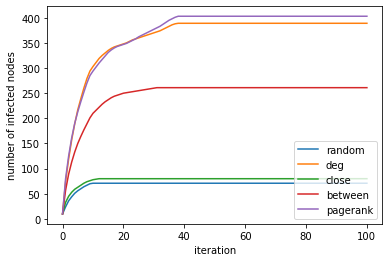

In [36]:
I=100
N=10
T = 0.5
S = 100

node_count_random = simulate_volatile(G, importance_measure=None, iterate=I, n=N, threshold=T, sample=S)    # number of infected nodes in each iteration, init with randomly selected nodes
node_count_deg = simulate_volatile(G, importance_measure=nx.degree_centrality, iterate=I, n=N, threshold=T, sample=S)        # number of infected nodes in each iteration, init with nodes of highest degree
node_count_closeness= simulate_volatile(G, importance_measure=nx.closeness_centrality, iterate=I, n=N, threshold=T, sample=S)  # number of infected nodes in each iteration, init with nodes of highest closeness centrality
node_count_betweenness = simulate_volatile(G, importance_measure=nx.betweenness_centrality, iterate=I, n=N, threshold=T, sample=S)  # number of infected nodes in each iteration, init with nodes of highest betweenness centrality
node_count_pagerank = simulate_volatile(G, importance_measure=nx.pagerank, iterate=I, n=N, threshold=T, sample=S)   # number of infected nodes in each iteration, init with nodes of highest pagerank 

# YOUR CODE HERE
data_tuples = list(zip(node_count_random,node_count_deg, node_count_closeness, node_count_betweenness, node_count_pagerank))

df = pd.DataFrame(data_tuples, columns=['random','deg', 'close', 'between', 'pagerank'])

df['iteration'] = np.arange(len(df))




plt.plot(df['iteration'], df['random'], label = "random")
plt.plot(df['iteration'], df['deg'], label = "deg")
plt.plot(df['iteration'], df['close'], label = "close")
plt.plot(df['iteration'], df['between'], label = "between")
plt.plot(df['iteration'], df['pagerank'], label = "pagerank")
plt.xlabel("iteration")
plt.ylabel("number of infected nodes")
plt.legend(loc="lower right")
plt.show()

### Q20. (8 points) Based on your results in the Q19, given the same set of seed nodes and a sample size within $[0,5]$, how does the total number of infected nodes change as you increase the number of sampled neighbors? Why?

**Hint**: Note that we using a relatively high $T$ of 0.5. Think about what this implies about the chances that a node becomes infected when using a large vs. a small sample size. 

Generally speaking, as the sample sizes increase from 1 to 5, the number of infected nodes converges more quickly regardless of which importance measure is used. Regardless of the threshold that is put in place, the more nodes that exist in a network, the greater chance that any number of nodes will get infected, simply as a consequence of there being more nodes to infect. Each node will likely have more connections to more neighbors, and thus, will have more opportunities to infect. 

The changes are more pronounced for the random and closeness centrality importance measures than the others, in the sense that they converge the quickest as the sample size increases within [0,5]. This somewhat makes sense, as closeness centrality doesn't have quite as much bearing regarding the amount of influence a node has in terms of its influence on the flow of infection, unlike a score like betweeness, which quantifies how well a node can act like a "shortest path bridge" between all other nodes(in other words, how well it can facilitate infection).

# End